# Run mulitple of ML models on GPU with SageMaker Multi-model endpoints

<div class="alert alert-info"> 💡 <strong> Note </strong>
SageMaker Multi-Model Endpoint with GPU support is a beta feature and is not recommended for production use cases
</div>

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) helps data scientists and developers prepare, build, train, and deploy high-quality machine learning (ML) models quickly by bringing together a broad set of capabilities purpose-built for ML. SageMaker accelerates innovation within your organization by providing purpose-built tools for every step of ML development, including labeling, data preparation, feature engineering, statistical bias detection, AutoML, training, tuning, hosting, explainability, monitoring, and workflow automation.

Customers are training ML models to cater individual users, granular market segments, hyper personalized content etc. For example, a call center analytics application using NLP language translation service to serve customers from different geographic location train custom models for different languages. Building large number of custom models can increase the cost of inference and managing models. These challenges become more pronounced when not all models are accessed at the same rate but still need to be available at all times.


This notebook was tested with the `conda_python3` kernel on an Amazon SageMaker notebook instance of type `g5`.

## SageMaker Multi-Model Endpoints with GPU

SageMaker multi-model endpoints(MME) provide a scalable and cost-effective way to deploy large numbers of ML models in the cloud. SageMaker multi-model endpoints enable you to deploy multiple ML models behind a single endpoint and serve them using a single serving container. Today, customers can use MME on CPU based instance types limiting them to deploy deep learning models that need accelerated compute GPUs. With announcement of new private beta feature, customer can host and serve deep learning GPU models using SageMaker multi-model endpoint. 

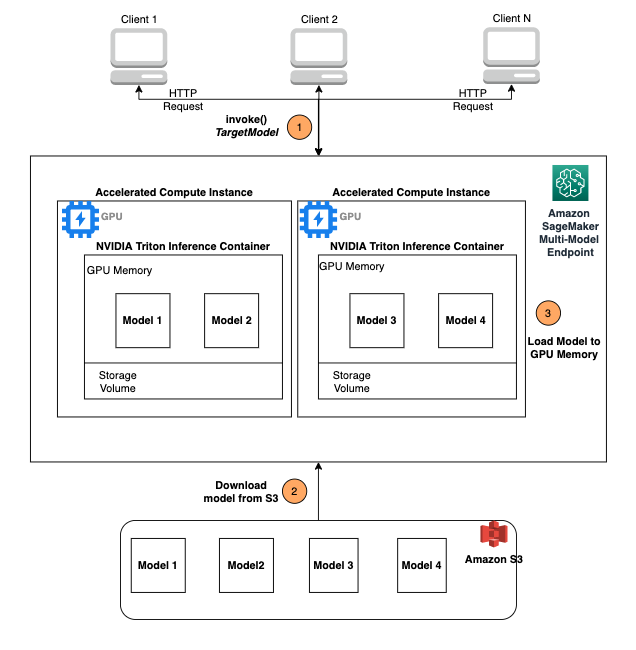

In [1]:
from IPython import display
display.Image("images/mme-gpu1.png")

## Amazon SageMaker Multi-Model endpoints with GPU Support

Amazon SageMaker multi-model endpoints with GPU works with NVIDIA Triton Inference Server (https://github.com/triton-inference-server/server/), which was developed specifically to enable scalable, cost-effective, and easy deployment of models in production. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance. It has support for multiple frameworks such as TensorFlow GraphDef, TensorFlow SavedModel, ONNX, PyTorch TorchScript, TensorRT, RAPIDS FIL for tree based models, and OpenVINO model formats. Triton has multiple built-in scheduling and batching algorithms that combine individual inference requests together to improve inference throughput.

1. You can invoke a model behind SageMaker MME by specifying the target model in the invocation request. SageMaker manages the lifecycle of the models in MME, routes traffic to the right instance behind the endpoint where the target model is loaded.
2. SageMaker dynamically loads models from Amazon Simple Storage Service(S3) to the instance’s storage volume. Once a model is downloaded onto instance storage volume, SageMaker doesn’t download the model again from S3. If the instance storage volume reaches capacity, SageMaker deletes any unused models from the storage volume.
3. SageMaker loads the model to NVIDIA Triton container memory on GPU enabled instance and serve the inference request. If the model is already loaded in the container memory, the subsequents requests are served faster as SageMaker does not need to download and load it again.
4. SageMaker continues to routes traffics to the instance where the model is loaded. If the instance resources reach capacity due to high utilization,  SageMaker unloads least used models from the container to free up resource to load more frequently used models.
5. Also, SageMaker MME can horizontally scale using auto-scaling policy, provision additional GPU compute instances based on metrics such as GPU utilization, memory utilization etc to serve spiky traffic to MME endpoints.

### Installs

Installs the dependencies required to package the model and run inferences using Triton server. Update SageMaker, boto3, awscli etc

In [49]:
!pip install -qU pip awscli boto3 sagemaker
!pip install nvidia-pyindex --quiet
!pip install tritonclient[http] --quiet
!pip install transformers[sentencepiece] --quiet

### Imports and variables

In [51]:
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
s3_client = boto3.client('s3')
role = get_execution_role()
bucket = sagemaker.Session().default_bucket()
prefix = "triton-mme-gpu"
region = boto3.Session().region_name

### Add utility methods for preparing request payload



The `tritonclient` package provides utility methods to generate the payload without having to know the details of the specification. We'll use the following methods to convert our inference request into a binary format which provides lower latencies for inference.

In [27]:
text = "summarize: SageMaker enables customers to deploy a model using custom code with NVIDIA Triton Inference Server. This functionality is available through the development of Triton Inference Server Containers. These containers include NVIDIA Triton Inference Server, support for common ML frameworks, and useful environment variables that let you optimize performance on SageMaker. For a list of all available Deep Learning Containers images, see Available Deep Learning Containers Images. Deep Learning Containers images are maintained and regularly updated with security patches."

In [8]:
text = ["summarize: SageMaker enables customers to deploy a model using custom code with NVIDIA",
        "translate English to German: The house is wonderful."
       ]

In [43]:
import tritonclient.http as httpclient
from transformers import AutoTokenizer
import numpy as np

def get_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.model_max_length = 512
    return tokenizer

def tokenize_text(model_name, text):
    tokenizer = get_tokenizer(model_name)
    tokenized_text = tokenizer(text, padding="max_length", return_tensors="np")
    return tokenized_text.input_ids, tokenized_text.attention_mask


def get_tokenized_text_binary(model_name, text):
    inputs = []
    outputs = []
    input_ids, attention_mask = tokenize_text(model_name, text)
    inputs.append(httpclient.InferInput("input_ids", input_ids.shape, "INT32"))
    inputs.append(httpclient.InferInput("attention_mask", attention_mask.shape, "INT32"))

    inputs[0].set_data_from_numpy(input_ids.astype(np.int32), binary_data=True)
    inputs[1].set_data_from_numpy(attention_mask.astype(np.int32), binary_data=True)
    
    output_name = "output" if model_name == "t5-small" else "logits"
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length

In [34]:
bert = "distilbert-base-uncased-finetuned-sst-2-english"
t5 = "t5-small"

## Workflow Overview

This section presents overview of main steps for preparing DistilBERT TensorFlow model (served using TensorFlow backend) and T5 Pytorch (served using Python backend) model to be served using Triton Inference Server.
### 1. Generate Model Artifacts

#### DistilBERT TensorFlow model

First, we use HuggingFace transformers to load pre-trained DistilBERT TensorFlow model that has been fine-tuned for sentiment analysis binary classification task. Then, we save the model as SavedModel serialized format. The `generate_distilbert_tf.sh` bash script performs all these steps inside the NGC TensorFlow container. 

In [9]:
!docker run --gpus=all --ipc=host --ulimit memlock=-1 --ulimit stack=67108864 --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/tensorflow:22.09-tf2-py3 \
            /bin/bash generate_distilbert_tf.sh

Unable to find image 'nvcr.io/nvidia/tensorflow:22.09-tf2-py3' locally
22.09-tf2-py3: Pulling from nvidia/tensorflow

20708c8b: Pulling fs layer 
25430193: Pulling fs layer 
583c6b12: Pulling fs layer 
be10edc2: Pulling fs layer 
d046b7e1: Pulling fs layer 
e997e3c2: Pulling fs layer 
45bfbc9d: Pulling fs layer 
67d9ff4b: Pulling fs layer 
96db94d9: Pulling fs layer 
aac63bdf: Pulling fs layer 
a652228e: Pulling fs layer 
be10edc2: Waiting fs layer 
d046b7e1: Waiting fs layer 
e997e3c2: Waiting fs layer 
885395bd: Pulling fs layer 
ff9b789b: Pulling fs layer 
aba32b97: Pulling fs layer 
02c3a422: Pulling fs layer 
5bfbc9d: Waiting fs layer 
ccfc15f8: Pulling fs layer 
7d9ff4b: Waiting fs layer 
03c92757: Pulling fs layer 
6db94d9: Waiting fs layer 
8846924e: Pulling fs layer 
42b86298: Pulling fs layer 
ac63bdf: Waiting fs layer 
652228e: Waiting fs layer 
f4fd0fdc: Pulling fs layer 
485f5ad0: Pulling fs layer 
1f6b2d00: Pulling fs layer 
859795ff: Pulling fs layer 
491d736c: Pulling f

#### T5 PyTorch Model

In case of T5-small HuggingFace PyTorch Model, since we are serving it using Triton's [python backend](https://github.com/triton-inference-server/python_backend#usage) we have python script [model.py](./workspace/model.py) which implements all the logic to initialize the T5 model and execute inference for the summarization task.

### 2. Build Model Respository

Using Triton on SageMaker requires us to first set up a [model repository](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md) folder containing the models we want to serve. For each model we need to create a model directory consisting of the model artifact and define config.pbtxt file to specify [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) which Triton uses to load and serve the model. 



#### DistilBERT TensorFlow Model

Model repository structure for DistilBERT TensorFlow Model.

```
distilbert_tf
├── 1
│   └── model.savedmodel
└── config.pbtxt
```

Model configuration must specify the platform and backend properties, max_batch_size property and the input and output tensors of the model. Additionally, you can specify instance_group and dynamic_batching properties for optimal inference performance in terms of latency and concurrency.

Below we set up the DistilBERT TensorFlow Model in the model repository:

In [13]:
!mkdir -p model_repository/distilbert_tf/1
!cp -r workspace/hf_distilbert/saved_model/1 workspace/model.savedmodel
!cp -r workspace/model.savedmodel model_repository/distilbert_tf/1/

Then we define its config file:

In [8]:
%%writefile model_repository/distilbert_tf/config.pbtxt
name: "distilbert_tf"
platform: "tensorflow_savedmodel"
max_batch_size: 8
input: [
    {
        name: "input_ids"
        data_type: TYPE_INT32
        dims: [ -1 ]
    },
    {
        name: "attention_mask"
        data_type: TYPE_INT32
        dims: [ -1 ]
    }
]
output: [
    {
        name: "logits"
        data_type: TYPE_FP32
        dims: [ 2 ]
    }
]
instance_group {
  count: 1
  kind: KIND_GPU
}
dynamic_batching {
  preferred_batch_size: 4
}

Overwriting model_repository/distilbert-tf/config.pbtxt


#### T5 Python Backend Model

Model repository structure for T5 Model.

```
t5
├── 1
│   └── model.py
└── config.pbtxt
```


Next we set up the T5 PyTorch Python Backend Model in the model repository:

In [16]:
!mkdir -p model_repository/t5_pytorch/1
!cp workspace/model.py model_repository/t5_pytorch/1/

##### Create Conda Environment for Dependencies

For serving the HuggingFace T5 PyTorch Model using Triton's Python backend we have PyTorch and HuggingFace transformers as dependencies.

We follow the instructions from the [Triton documentation for packaging dependencies](https://github.com/triton-inference-server/python_backend#2-packaging-the-conda-environment) to be used in the python backend as conda env tar file. The bash script [create_hf_env.sh]('./workspace/create_hf_env.sh') creates the conda environment containing PyTorch and HuggingFace transformers, packages it as tar file and then we move it into the t5-pytorch model directory.

In [115]:
!bash workspace/create_hf_env.sh
!mv hf_env.tar.gz model_repository/t5_pytorch/

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/hf_env

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  ca-certificates    conda-forge/linux-64::ca-certificates-2022.9.24-ha878542_0
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.39-hc81fddc_0
  libffi             conda-forge/linux-64::libffi-3.4.2-h7f98852_5
  libgcc-ng          conda-forge/linux-64::libgcc-ng-12.2.0-h65d4601_18
  libgomp            conda-forge/linux-64::libgomp-12.2.0-h65d4601_18
  libnsl             conda-forge/linux-64::libn

After creating the tar file from the conda environment and placing it in model folder, you need to tell Python backend to use that environment for your model. We do this by including the lines below in the model `config.pbtxt` file:

```
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "$$TRITON_MODEL_DIRECTORY/hf_env.tar.gz"}
}
```
Here, `$$TRITON_MODEL_DIRECTORY` helps provide environment path relative to the model folder in model repository and is resolved to `$pwd/model_repository/t5_pytorch`. Finally `hf_env.tar.gz` is the name we gave to our conda env file.

Now we are ready to define the config file for t5 pytorch model being served through Triton's Python Backend:

In [116]:
%%writefile model_repository/t5_pytorch/config.pbtxt
name: "t5"
backend: "python"
max_batch_size: 8
input: [
    {
        name: "input_ids"
        data_type: TYPE_INT32
        dims: [ -1 ]
    },
    {
        name: "attention_mask"
        data_type: TYPE_INT32
        dims: [ -1 ]
    }
]
output [
  {
    name: "output"
    data_type: TYPE_INT32
    dims: [ -1 ]
  }
]
instance_group {
  count: 1
  kind: KIND_GPU
}
dynamic_batching {
  preferred_batch_size: 4
}
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "$$TRITON_MODEL_DIRECTORY/hf_env.tar.gz"}
}

Overwriting model_repository/t5_pytorch/config.pbtxt


### 3. Package models and upload to S3

Next, we will package our models as `*.tar.gz` for uploading to S3. 

In [117]:
!tar -C model_repository/ -czf distilbert_tf.tar.gz distilbert_tf
model_uri_distilbert_tf = sagemaker_session.upload_data(path="distilbert_tf.tar.gz", key_prefix=prefix)

In [118]:
!tar -C model_repository/ -czf t5_pytorch.tar.gz t5_pytorch
model_uri_t5_pytorch = sagemaker_session.upload_data(path="t5_pytorch.tar.gz", key_prefix=prefix)

### 4. Create SageMaker Endpoint

Now that we have 2 different models, we start off by creating a [sagemaker model](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateModel.html) from the model files we uploaded to s3 in the previous step.

In this step we also provide an additional Environment Variable i.e. `SAGEMAKER_TRITON_DEFAULT_MODEL_NAME` which specifies the name of the model to be loaded by Triton. **The value of this key should match the folder name in the model package uploaded to s3**. This variable is optional in case of a single model. In case of ensemble models, this key **has to be** specified for Triton to startup in SageMaker.

Additionally, customers can set `SAGEMAKER_TRITON_BUFFER_MANAGER_THREAD_COUNT` and `SAGEMAKER_TRITON_THREAD_COUNT` for optimizing the thread counts.

`model_data_url` is the S3 directory that contains all the models that SageMaker mulit-model endpoint will use to load  and serve predictions. `Mode` indicated the mode in which SageMaker would host this model - `MultiModel`

In [119]:
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}
base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.09-py3".format(
    account_id=account_id_map[region], region=region, base=base
)

In [120]:
model_data_url = f"s3://{bucket}/{prefix}/"

container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "triton_mme_gpu"},
}

Once the image, data location are set we create the model using `create_model` by specifying the `ModelName` and the Container definition

In [121]:
sm_model_name = "triton-mme-gpu" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-west-2:354625738399:model/triton-mme-gpu2022-10-23-07-51-09


Using the model above, we create an [endpoint configuration](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html) where we can specify the type and number of instances we want in the endpoint.

In [122]:
endpoint_config_name = "triton-mme-gpu-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-west-2:354625738399:endpoint-config/triton-mme-gpu-2022-10-23-07-51-09


Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to **InService** once the deployment is successful.

In [123]:
endpoint_name = "triton-mme-gpu-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-west-2:354625738399:endpoint/triton-mme-gpu-2022-10-23-07-51-09


In [124]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:354625738399:endpoint/triton-mme-gpu-2022-10-23-07-51-09
Status: InService


### 5. Run Inference

#### DistilBERT TensorFlow Model

In [125]:
distilbert = "distilbert-base-uncased-finetuned-sst-2-english"

In [126]:
bert_text = ["That movie was bad", "She looked stunning"]

In [127]:
request_body, header_length = get_tokenized_text_binary(distilbert, bert_text)

In [128]:
response = runtime_sm_client.invoke_endpoint(EndpointName=endpoint_name,
                                  ContentType='application/vnd.sagemaker-triton.binary+json;json-header-size={}'.format(header_length),
                                  Body=request_body,
                                 TargetModel='distilbert_tf.tar.gz')

In [129]:
# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response['ContentType'][len(header_length_prefix):]
output_name = "logits"
# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response['Body'].read(), header_length=int(header_length_str))
logits = result.as_numpy(output_name)

In [130]:
CLASSES = ["NEGATIVE", "POSITIVE"]
predictions = []

for i in range(len(logits)):
    pred_class_idx = np.argmax(logits[i])
    predictions.append(CLASSES[pred_class_idx])
print(predictions)

['NEGATIVE', 'POSITIVE']


#### T5 PyTorch Model

In [131]:
t5 = "t5-small"

In [132]:
t5_text = ["summarize: SageMaker enables customers to deploy a model using custom code with NVIDIA"]

In [133]:
request_body, header_length = get_tokenized_text_binary(t5, t5_text)

In [134]:
response = runtime_sm_client.invoke_endpoint(EndpointName=endpoint_name,
                                  ContentType='application/vnd.sagemaker-triton.binary+json;json-header-size={}'.format(header_length),
                                  Body=request_body,
                                 TargetModel='t5_pytorch.tar.gz')

In [135]:
# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response['ContentType'][len(header_length_prefix):]
output_name = "output"
# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response['Body'].read(), header_length=int(header_length_str))
output_data = result.as_numpy(output_name)

In [136]:
output_data

array([[    0, 21429, 22638,    52,     3,  7161,   722,    12, 17274,
            3,     9,   825,   338,  1653,  1081,    28,   445,  7765,
        24605,     3]], dtype=int32)

In [137]:
t5_tokenizer = get_tokenizer(t5)

In [ ]:
d

In [ ]:
decoded_output = t5_tokenizer.decode(
            output_data[0],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )
decoded_output

We can also use binary+json as the payload format to get better performance for the inference call. The specification of this format is provided [here](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md).

**Note:** With the `binary+json` format, we have to specify the length of the request metadata in the header to allow Triton to correctly parse the binary payload. This is done using a custom Content-Type header `application/vnd.sagemaker-triton.binary+json;json-header-size={}`.

Please not, this is different from using `Inference-Header-Content-Length` header on a stand-alone Triton server since custom headers are not allowed in SageMaker.

In [ ]:
request_body, header_length = get_sample_image_binary_pt()

response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(header_length),
            Body=request_body,
            TargetModel='efficientnet_b7_pt_v1.tar.gz', 
        )

# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response["ContentType"][len(header_length_prefix) :]

# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response["Body"].read(), header_length=int(header_length_str)
)
output0_data = result.as_numpy("OUTPUT__0")
print(output0_data)

### Terminate endpoint and clean up artifacts

In [114]:
sm_client.delete_model(ModelName=sm_model_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'd1efa9b2-5409-4fd7-906a-0e6bbf63fe52',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd1efa9b2-5409-4fd7-906a-0e6bbf63fe52',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 23 Oct 2022 07:44:53 GMT'},
  'RetryAttempts': 0}}